# Copy of Cle Elum Ridge (CER) xDEM
## using it on the NCALM snow depth and the RAPID snow depth pre-and post-treatment 

### Notebook contents 
* using xDEM to create variograms

created by Cassie Lumbrazo\
date: October 2023\
python environment: **raster_xdem**
* Created new env: clone of *raster* from Linux box, called *raster_xdem* for the xdem package

In [2]:
# import packages 
# %matplotlib widget
# %matplotlib inline #have to remote this to get rid of the scikit-gstat warning with plotting... 

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# interactive plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots # adding for subplots
import plotly.figure_factory as ff

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
# import rasterstats
import scipy

In [3]:
# sns.set_theme()
plt.rcParams['figure.figsize'] = [12,6] #overriding size

In [4]:
!conda env list

# conda environments:
#
                         /home/lumbraca/mambaforge/envs/pysolar
                         /home/lumbraca/mambaforge/envs/raster
                      *  /home/lumbraca/mambaforge/envs/raster_xdem
                         /home/lumbraca/mambaforge/envs/treeinterpreter
base                     /opt/miniconda3
python                   /opt/miniconda3/envs/python



In [5]:
# labels and cosntants 
# titles
cer_title = 'CER Small Domain'

# labels 
dce_label = 'distance to canopy edge (m)'
dah_label = 'diurnal anisotropic heat index'
slope_label = 'slope (degrees)'
aspect_label = 'aspect (degrees)'
snow_label = 'snow depth (m)'

dceclassdict = {1: 'Large Clusters', 2: 'Small Clusters', 3: 'Edges', 4: 'Small Gaps', 5: 'Large Gaps'}

In [6]:
# ds = xr.open_dataset('/home/lumbraca/raster/data/cer_smalldomain_create_netcdf.nc')
# ds

ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros
# ds.close() # how to close a dataset 

In [7]:
# first creating a binary mask
# if there are values then 1, if not then 0 
chm_mask = ds['chmws_rapid'].copy(deep=True) # first cope chmws
chm_mask = chm_mask.fillna(-1000) # then filling the nans in the mask with 500 to make this easier
chm_mask = chm_mask.where(chm_mask < -50, 1) # where condition is FALSE, fill with 1 
chm_mask = chm_mask.where(chm_mask > -50, 0) # where condition is FALSE, fill with 0 

# now, we take the dce_mask and do the erosion thing with it to create the fixed mask 
fixed_mask = scipy.ndimage.binary_erosion(chm_mask, structure=np.ones((1,10,10))).astype(chm_mask.dtype) # had to add the 1 to the 50x50 for dimensions

# For the chmws mask, we do not accoutn for large edge effects, so a buffer of 5-10 meters should work. Let's do 10. 

# add the fixed mask to the dataset 
ds['chm_mask'] = xr.DataArray(fixed_mask,dims = ['band','y','x'])

# Now, go mask my OG dataset by the fixed_mask to remove the edges of dce 
ds['chmws_rapid_raw'] = ds['chmws_rapid'].copy(deep=True) # saving dce into a variable for the dataset 
ds['chmws_rapid'] = ds['chmws_rapid'].where(ds['chm_mask'] >= 1) # resaving the mask dce into dce variable 

ds = ds.where(ds.chmws_rapid.notnull()) # making the entire dataset null where there is no data here 

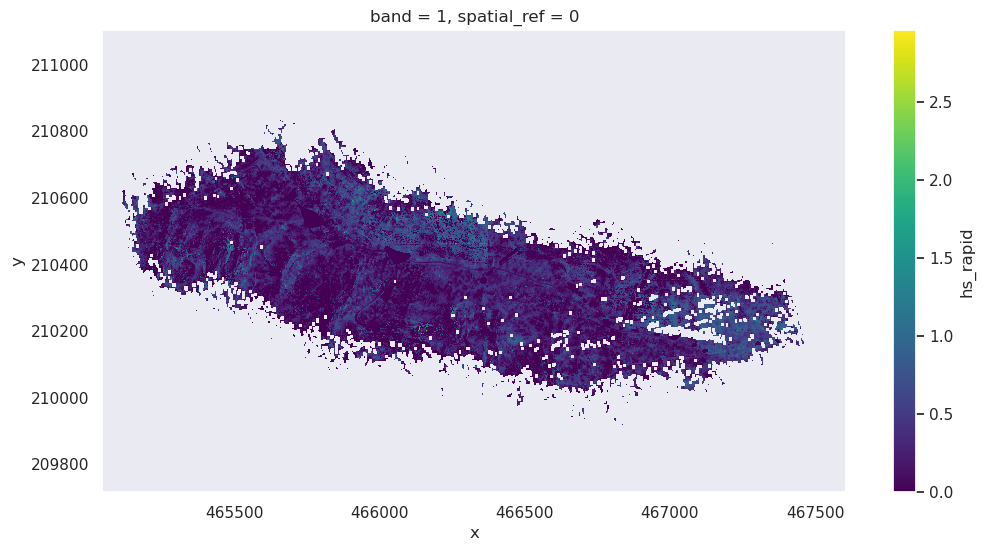

In [8]:
ds.hs_rapid.plot()

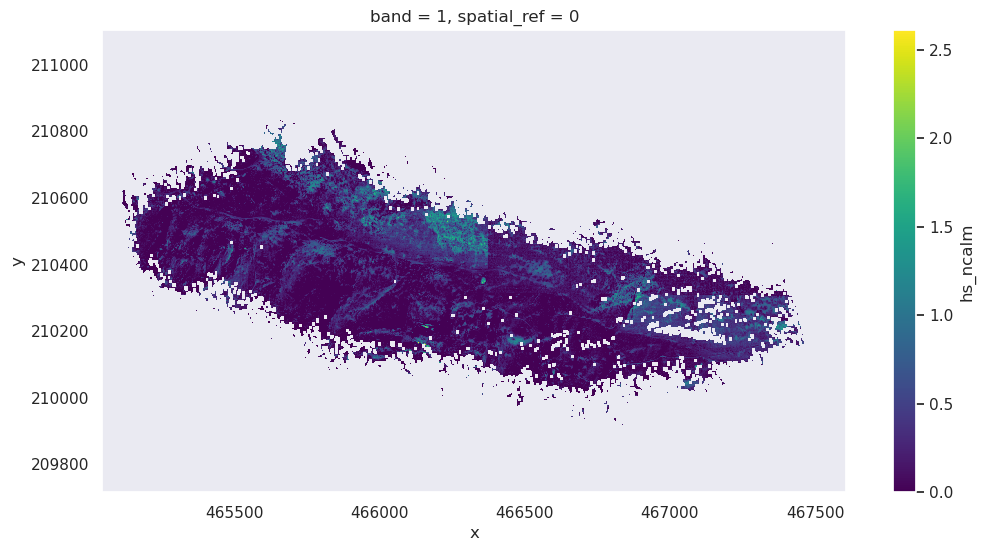

In [9]:
ds.hs_ncalm.plot()

# xDEM

In [10]:
import xdem

/home/lumbraca/mambaforge/envs/raster_xdem/lib/python3.11/site-packages/skgstat/models.py:22: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/lumbraca/mambaforge/envs/raster_xdem/lib/python3.11/site-packages/skgstat/models.py:86: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/lumbraca/mambaforge/envs/raster_xdem/lib/python3.11/site-packages/sk

/home/lumbraca/mambaforge/envs/raster_xdem/lib/python3.11/site-packages/xdem/spatialstats.py:2382: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((nd3type, nd3type, nd4type))  # type: ignore


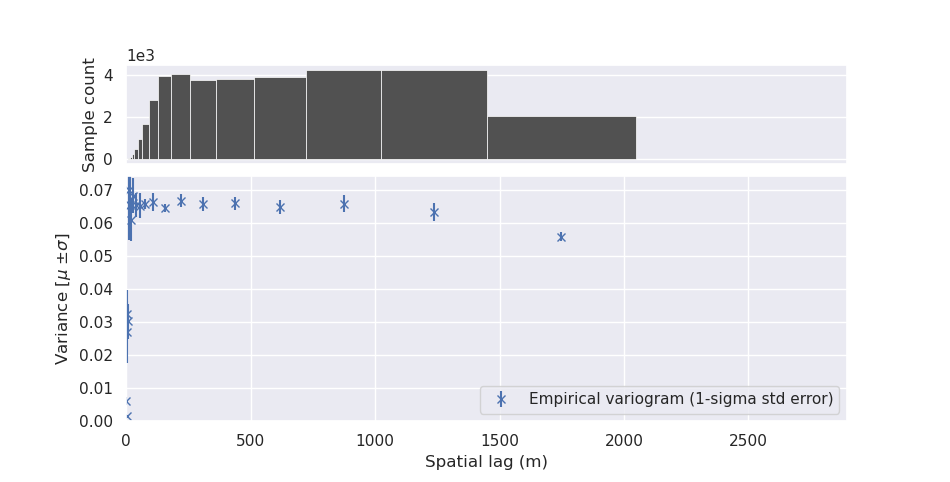

In [11]:
# for all rapid post-treatment snow depth
var_snowdepth_rapid = xdem.spatialstats.sample_empirical_variogram(
    values=ds.hs_rapid.to_numpy(), gsd=1, subsample=100, n_variograms=10, random_state=42
)

xdem.spatialstats.plot_variogram(var_snowdepth_rapid)

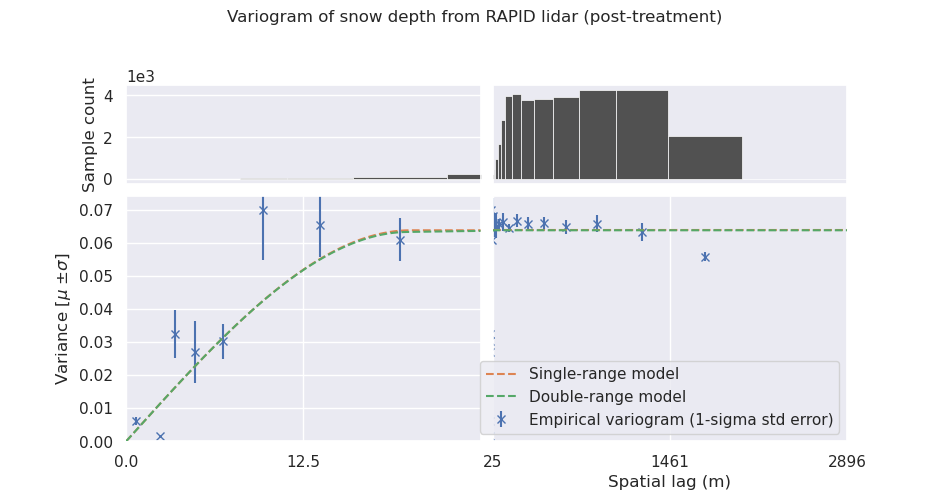

In [12]:
# var_snowdepth = xdem.spatialstats.sample_empirical_variogram(
#     values=ds.snowdepth.to_numpy(), gsd=1, subsample=1000, n_variograms=10, random_state=42
# )

data = var_snowdepth_rapid

# Create the functions
func_sum_vgm1, params_vgm1 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical"], empirical_variogram=data
)

func_sum_vgm2, params_vgm2 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical", "Spherical"], empirical_variogram=data
)

# Plot
xdem.spatialstats.plot_variogram(
    data,
    list_fit_fun=[func_sum_vgm1, func_sum_vgm2],
    list_fit_fun_label=["Single-range model", "Double-range model"],
    xscale_range_split=[25],
)

plt.title("Variogram of snow depth from RAPID lidar (post-treatment)")
plt.show()

Now, make for NCALM lidar snow depth (pre-treatment)

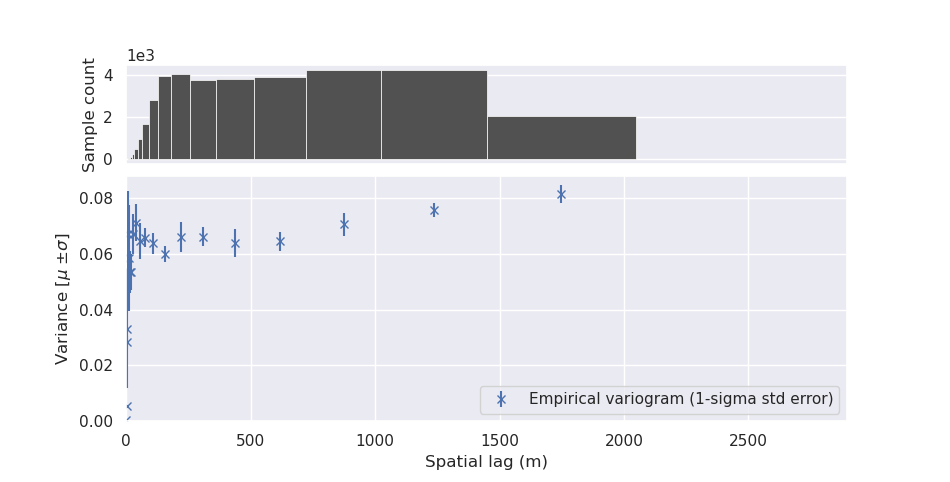

In [13]:
# for all rapid post-treatment snow depth
var_snowdepth_ncalm = xdem.spatialstats.sample_empirical_variogram(
    values=ds.hs_ncalm.to_numpy(), gsd=1, subsample=100, n_variograms=10, random_state=42
)

xdem.spatialstats.plot_variogram(var_snowdepth_ncalm)

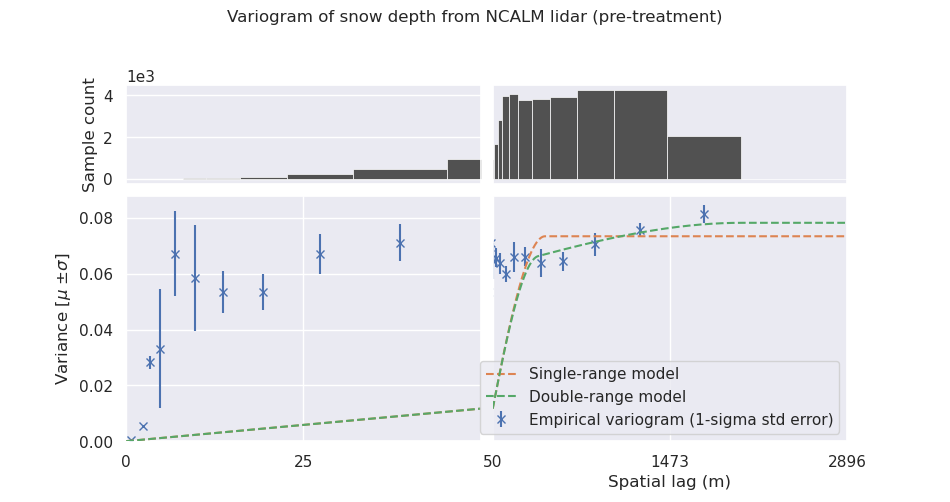

In [14]:
data = var_snowdepth_ncalm

# Create the functions
func_sum_vgm1, params_vgm1 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical"], empirical_variogram=data
)

func_sum_vgm2, params_vgm2 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical", "Spherical"], empirical_variogram=data
)

# Plot
xdem.spatialstats.plot_variogram(
    data,
    list_fit_fun=[func_sum_vgm1, func_sum_vgm2],
    list_fit_fun_label=["Single-range model", "Double-range model"],
    xscale_range_split=[50],
)

plt.title("Variogram of snow depth from NCALM lidar (pre-treatment)")
plt.show()

## Let's try to do the spatial lag, without the more conservative dataset
* cutting off all negative values without 10 cm error included in zero

In [15]:
# ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros
ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_cutatzero.nc') # for the snow depth values negative to zeros

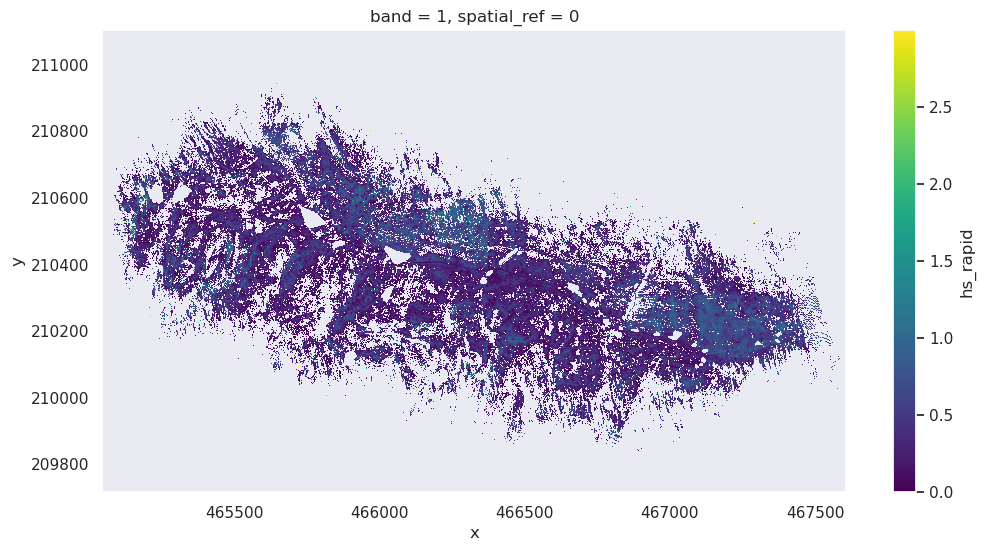

In [16]:
ds.hs_rapid.plot()

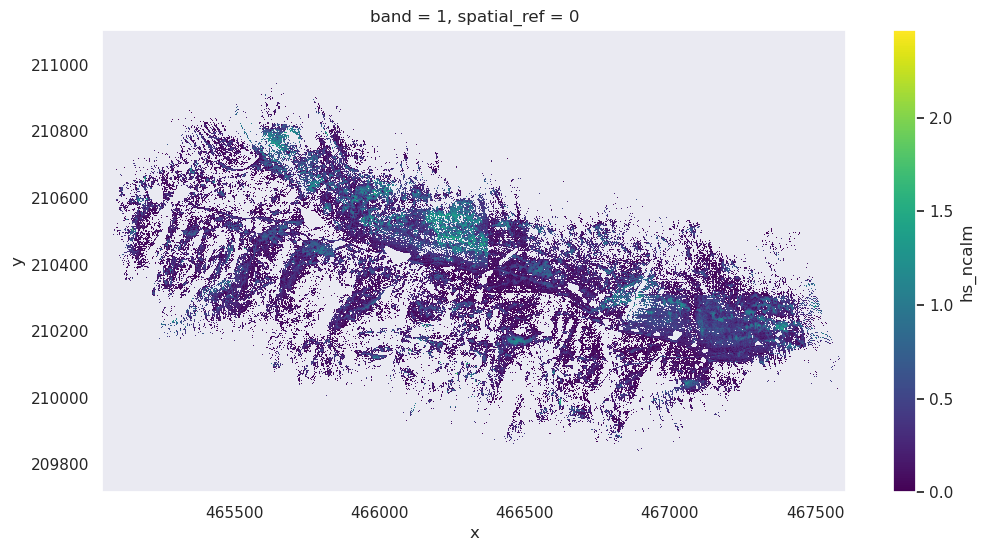

In [17]:
ds.hs_ncalm.plot()

# xDEM

Text(0.5, 1.0, 'Variogram of snow depth from RAPID lidar (post-treatment)\n using more conservative data cut out all small negative values')

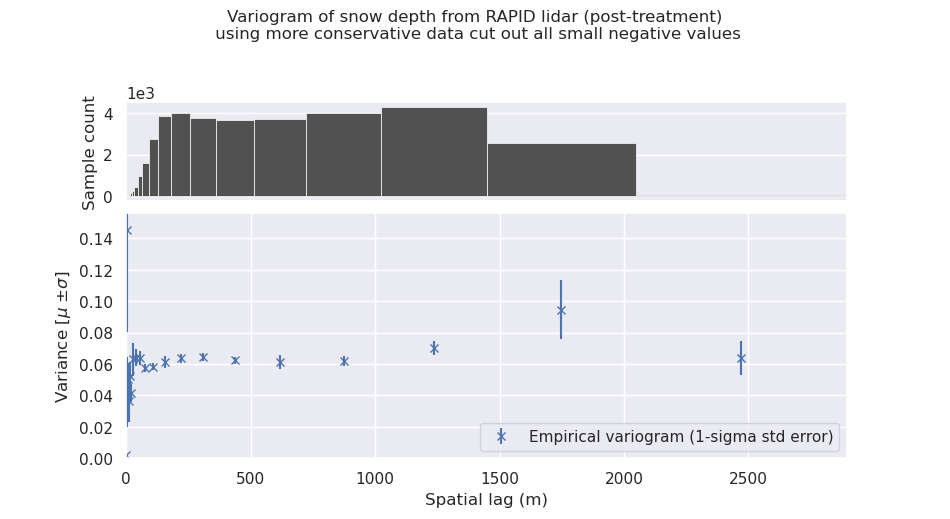

In [18]:
# for all rapid post-treatment snow depth
var_snowdepth_rapid = xdem.spatialstats.sample_empirical_variogram(
    values=ds.hs_rapid.to_numpy(), gsd=1, subsample=100, n_variograms=10, random_state=42
)

xdem.spatialstats.plot_variogram(var_snowdepth_rapid)
plt.title('Variogram of snow depth from RAPID lidar (post-treatment)\n using more conservative data cut out all small negative values')

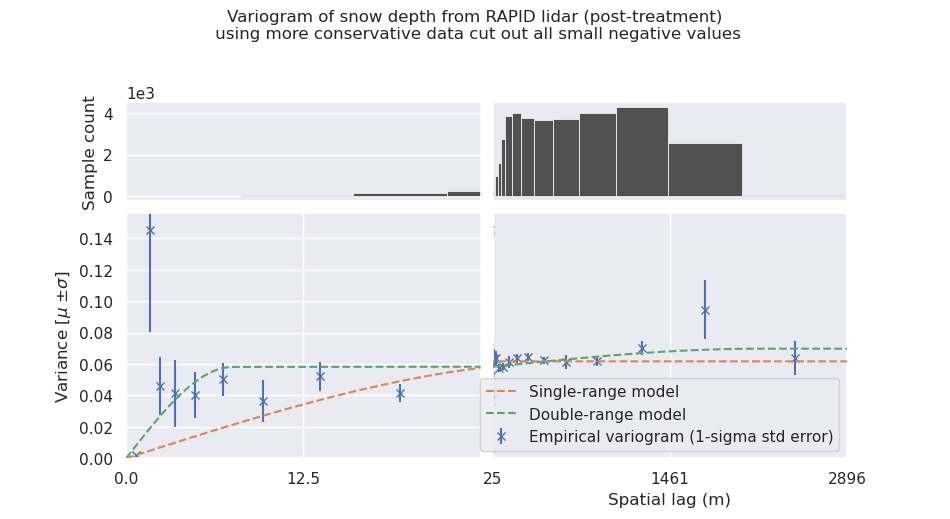

In [19]:
# var_snowdepth = xdem.spatialstats.sample_empirical_variogram(
#     values=ds.snowdepth.to_numpy(), gsd=1, subsample=1000, n_variograms=10, random_state=42
# )

data = var_snowdepth_rapid

# Create the functions
func_sum_vgm1, params_vgm1 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical"], empirical_variogram=data
)

func_sum_vgm2, params_vgm2 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical", "Spherical"], empirical_variogram=data
)

# Plot
xdem.spatialstats.plot_variogram(
    data,
    list_fit_fun=[func_sum_vgm1, func_sum_vgm2],
    list_fit_fun_label=["Single-range model", "Double-range model"],
    xscale_range_split=[25],
)

plt.title('Variogram of snow depth from RAPID lidar (post-treatment)\n using more conservative data cut out all small negative values')
plt.show()

Now, make for NCALM lidar snow depth (pre-treatment)

Text(0.5, 1.0, 'Variogram of snow depth from NCALM lidar (pre-treatment)\n using more conservative data cut out all small negative values')

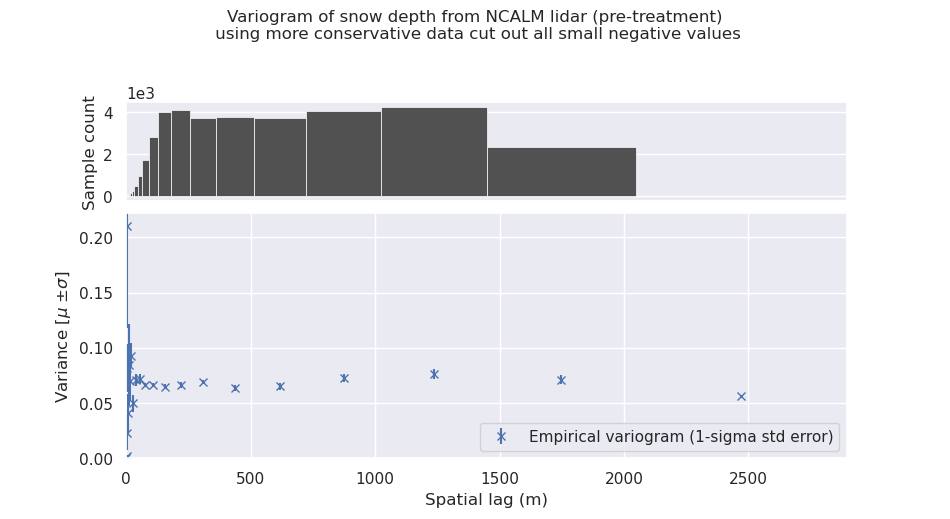

In [20]:
# for all rapid post-treatment snow depth
var_snowdepth_ncalm = xdem.spatialstats.sample_empirical_variogram(
    values=ds.hs_ncalm.to_numpy(), gsd=1, subsample=100, n_variograms=10, random_state=42
)

xdem.spatialstats.plot_variogram(var_snowdepth_ncalm)
plt.title('Variogram of snow depth from NCALM lidar (pre-treatment)\n using more conservative data cut out all small negative values')

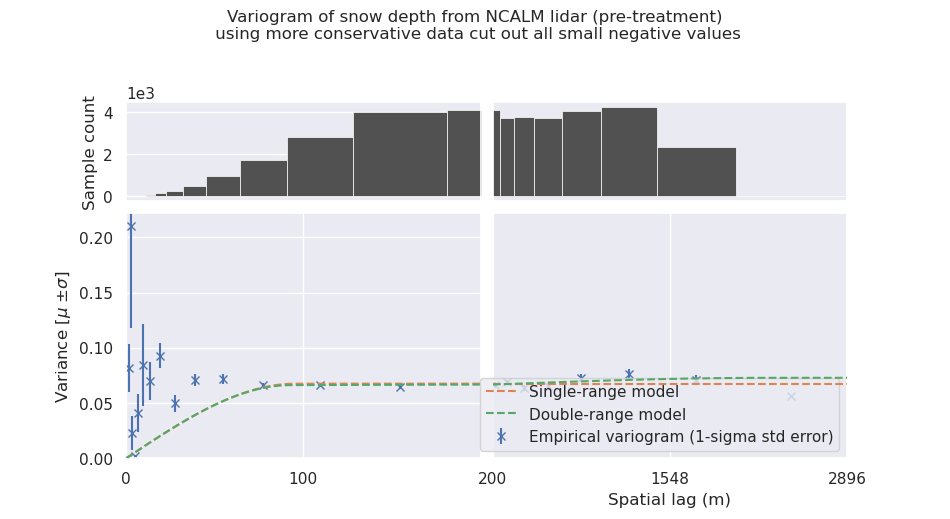

In [24]:
data = var_snowdepth_ncalm

# Create the functions
func_sum_vgm1, params_vgm1 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical"], empirical_variogram=data
)

func_sum_vgm2, params_vgm2 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical", "Spherical"], empirical_variogram=data
)

# Plot
xdem.spatialstats.plot_variogram(
    data,
    list_fit_fun=[func_sum_vgm1, func_sum_vgm2],
    list_fit_fun_label=["Single-range model", "Double-range model"],
    xscale_range_split=[200],
)

plt.title('Variogram of snow depth from NCALM lidar (pre-treatment)\n using more conservative data cut out all small negative values')
plt.show()

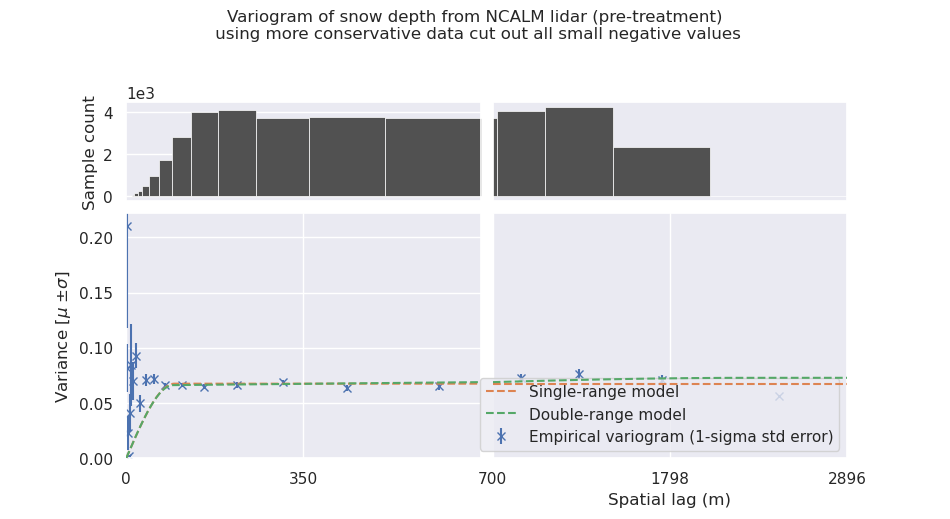

In [22]:
data = var_snowdepth_ncalm

# Create the functions
func_sum_vgm1, params_vgm1 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical"], empirical_variogram=data
)

func_sum_vgm2, params_vgm2 = xdem.spatialstats.fit_sum_model_variogram(
    list_models=["Spherical", "Spherical"], empirical_variogram=data
)

# Plot
xdem.spatialstats.plot_variogram(
    data,
    list_fit_fun=[func_sum_vgm1, func_sum_vgm2],
    list_fit_fun_label=["Single-range model", "Double-range model"],
    xscale_range_split=[700],
)

plt.title('Variogram of snow depth from NCALM lidar (pre-treatment)\n using more conservative data cut out all small negative values')
plt.show()

_______________________________________________________________
# OLD CODE BELOW
_______________________________________________________________

## Resample using xDEM
https://geoutils.readthedocs.io/en/stable/raster_class.html#reproject

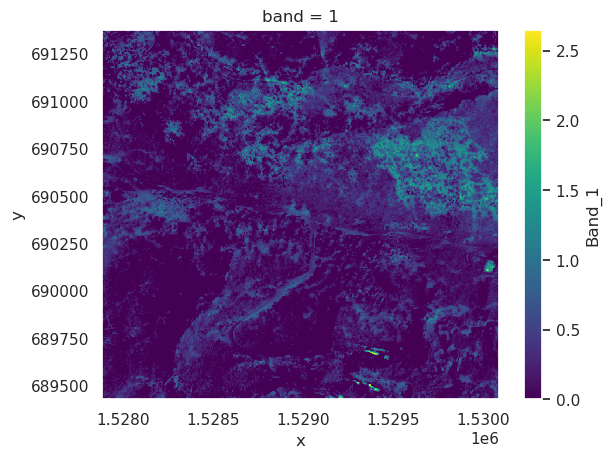

In [19]:
ds.snowdepth.plot()

Need to come back to this...

## Other Old Stats Stuff

## Non-parametric test for difference in the means

In [ ]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Kruskal-Wallis Test
* used to determine whether or not there is a statistically significant differences between the medians of three or more independent groups 
* is considered the non-parametric equivalent of One-Way ANOVA 
https://www.statology.org/kruskal-wallis-test-python/

In [ ]:
# trying Kruskal-Wallis Test, between only the dce groups
stats.kruskal(largeclusters_flat, smallclusters_flat, canopyedges_flat, smallgaps_flat, largegaps_flat)

KruskalResult(statistic=38200.12772889163, pvalue=0.0)

In [ ]:
# trying Kruskal-Wallis Test, between each dce group individually 
stats.kruskal(largeclusters_dahpos_flat, largeclusters_dahneg_flat) 
stats.kruskal(smallclusters_dahpos_flat, smallclusters_dahneg_flat) 
stats.kruskal(canopyedges_dahpos_flat, canopyedges_dahneg_flat) 
stats.kruskal(smallgaps_dahpos_flat, smallgaps_dahneg_flat) 
stats.kruskal(largegaps_dahpos_flat, largegaps_dahneg_flat) 

KruskalResult(statistic=10274.505201546732, pvalue=0.0)

In [ ]:
# trying Kruskal-Wallis Test, between all dah pos groups
stats.kruskal(largeclusters_dahpos_flat, smallclusters_dahpos_flat, canopyedges_dahpos_flat, smallgaps_dahpos_flat, largegaps_dahpos_flat)

KruskalResult(statistic=25108.023418095447, pvalue=0.0)

In [ ]:
# trying Kruskal-Wallis Test, between all dah neg groups
stats.kruskal(largeclusters_dahneg_flat, smallclusters_dahneg_flat, canopyedges_dahneg_flat, smallgaps_dahneg_flat, largegaps_dahneg_flat)

KruskalResult(statistic=42374.56839731968, pvalue=0.0)

### Non-parametric Multiple Comparisons Following the Kruskal-Wallis Test
* interested in which groups differ from others 
From the USGS Textbook Chapter 7 Page 209 

"A conceptually simple nonparametric MCT is evaluate group patterns following a Kruskal-Wallis test is to compute all possible pairwise Wilcoxon rank-sum tests, 

setting the tests' error rates to achieve the family error rate, $\alpha_{family}$"

In [ ]:
df_dah = pd.DataFrame(index=range(len(canopyedges_dahpos_flat)), columns=range(10))

df_dah[0].update(largeclusters_dahpos_flat)
df_dah[1].update(largeclusters_dahneg_flat)
df_dah[2].update(smallclusters_dahpos_flat)
df_dah[3].update(smallclusters_dahneg_flat)
df_dah[4].update(canopyedges_dahpos_flat)
df_dah[5].update(canopyedges_dahneg_flat)
df_dah[6].update(smallgaps_dahpos_flat)
df_dah[7].update(smallgaps_dahneg_flat)
df_dah[8].update(largegaps_dahpos_flat)
df_dah[9].update(largegaps_dahneg_flat)

In [ ]:
df_dah

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.063996,0.0,0.600447,0.0,0.777255
1,0.0,0.0,0.0,0.0,0.0,0.259035,0.0,0.646137,0.0,0.768102
2,0.0,0.0,0.0,0.0,0.0,0.48771,0.0,0.743694,0.0,0.734541
3,0.0,0.0,0.0,0.204192,0.0,0.03051,0.0,0.704106,0.0,0.649188
4,0.0,0.0,0.0,0.161553,0.0,0.042714,0.0,0.65529,0.0,0.646137
...,...,...,...,...,...,...,...,...,...,...
85717,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
85718,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
85719,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
85720,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# randomly sample from each group, 10,000

sample_size = 500

largeclusters_dahpos_sample = np.random.choice(largeclusters_dahpos_flat, sample_size)
smallclusters_dahpos_sample = np.random.choice(smallclusters_dahpos_flat, sample_size)
canopyedges_dahpos_sample   = np.random.choice(canopyedges_dahpos_flat, sample_size)
smallgaps_dahpos_sample     = np.random.choice(smallgaps_dahpos_flat, sample_size)
largegaps_dahpos_sample     = np.random.choice(largegaps_dahpos_flat, sample_size)

largeclusters_dahneg_sample = np.random.choice(largeclusters_dahneg_flat, sample_size)
smallclusters_dahneg_sample = np.random.choice(smallclusters_dahneg_flat, sample_size)
canopyedges_dahneg_sample   = np.random.choice(canopyedges_dahneg_flat, sample_size)
smallgaps_dahneg_sample     = np.random.choice(smallgaps_dahneg_flat, sample_size)
largegaps_dahneg_sample     = np.random.choice(largegaps_dahneg_flat, sample_size)

In [ ]:
# trying Wilcoxon Rank Sums Test between all possible groups 
# stats.wilcoxon(largeclusters_dahpos_flat, largeclusters_dahneg_flat)
# stats.wilcoxon(df_dah, nan_policy='omit')
# stats.wilcoxon(df_dah[0], df_dah[1], nan_policy='omit') # nan policy: propagate, omit, raise (error)

In [ ]:
stats.ranksums(largeclusters_dahpos_flat.mean(), largeclusters_dahneg_flat.mean())

RanksumsResult(statistic=-1.0, pvalue=0.31731050786291415)

In [ ]:
stats.ranksums(smallclusters_dahpos_flat.mean(), smallclusters_dahneg_flat.mean())

RanksumsResult(statistic=-1.0, pvalue=0.31731050786291415)

In [ ]:
stats.ranksums(smallgaps_dahpos_flat.mean(), smallgaps_dahneg_flat.mean())

RanksumsResult(statistic=-1.0, pvalue=0.31731050786291415)

### Mann-Whitney U Rank Test 
* trying to get around the issue of groups with different sizes

In [ ]:
# Mann Whitney U rank test on two independent samples 
# non-parametric test to determine is the underlying distrubution of sampel x is the same as y 
stats.mannwhitneyu(largeclusters_dahpos_flat, largeclusters_dahneg_flat)

MannwhitneyuResult(statistic=351348441.5, pvalue=0.0)

In [ ]:
# if each dce group is different to itself with dah neg or pos 
# s1, p1 = stats.mannwhitneyu(largeclusters_dahpos_flat, largeclusters_dahneg_flat) 
# s2, p2 = stats.mannwhitneyu(smallclusters_dahpos_flat, smallclusters_dahneg_flat) 
# s3, p3 = stats.mannwhitneyu(canopyedges_dahpos_flat, canopyedges_dahneg_flat) 
# s4, p4 = stats.mannwhitneyu(smallgaps_dahpos_flat, smallgaps_dahneg_flat) 
# s5, p5 = stats.mannwhitneyu(largegaps_dahpos_flat, largegaps_dahneg_flat) 

s1, p1 = stats.mannwhitneyu(largeclusters_dahpos_sample, largeclusters_dahneg_sample) 
s2, p2 = stats.mannwhitneyu(smallclusters_dahpos_sample, smallclusters_dahneg_sample) 
s3, p3 = stats.mannwhitneyu(canopyedges_dahpos_sample, canopyedges_dahneg_sample) 
s4, p4 = stats.mannwhitneyu(smallgaps_dahpos_sample, smallgaps_dahneg_sample) 
s5, p5 = stats.mannwhitneyu(largegaps_dahpos_sample, largegaps_dahneg_sample) 

print('P1', p1)
print('P2', p1)
print('P3', p1)
print('P4', p1)
print('P5', p1)

P1 3.3775569141157563e-46
P2 3.3775569141157563e-46
P3 3.3775569141157563e-46
P4 3.3775569141157563e-46
P5 3.3775569141157563e-46


In [ ]:
# Now, comparing only pos dah groups against all dce groups 
# For DAH pos
# for all data 
# s6, p6 = stats.mannwhitneyu(largeclusters_dahpos_flat, smallclusters_dahpos_flat) 
# s7, p7 = stats.mannwhitneyu(largeclusters_dahpos_flat, canopyedges_dahpos_flat) 
# s8, p8 = stats.mannwhitneyu(largeclusters_dahpos_flat, smallgaps_dahpos_flat) 
# s9, p9 = stats.mannwhitneyu(largeclusters_dahpos_flat, largegaps_dahpos_flat) 

# s10, p10 = stats.mannwhitneyu(smallclusters_dahpos_flat, canopyedges_dahpos_flat) 
# s11, p11 = stats.mannwhitneyu(smallclusters_dahpos_flat, smallgaps_dahpos_flat) 
# s12, p12 = stats.mannwhitneyu(smallclusters_dahpos_flat, largegaps_dahpos_flat) 

# s13, p13 = stats.mannwhitneyu(canopyedges_dahpos_flat, smallgaps_dahpos_flat) 
# s14, p14 = stats.mannwhitneyu(canopyedges_dahpos_flat, largegaps_dahpos_flat) 

# s15, p15 = stats.mannwhitneyu(smallgaps_dahpos_flat, largegaps_dahpos_flat) 

# random sample
s6, p6 = stats.mannwhitneyu(largeclusters_dahpos_sample, smallclusters_dahpos_sample) 
s7, p7 = stats.mannwhitneyu(largeclusters_dahpos_sample, canopyedges_dahpos_sample) 
s8, p8 = stats.mannwhitneyu(largeclusters_dahpos_sample, smallgaps_dahpos_sample) 
s9, p9 = stats.mannwhitneyu(largeclusters_dahpos_sample, largegaps_dahpos_sample) 

s10, p10 = stats.mannwhitneyu(smallclusters_dahpos_sample, canopyedges_dahpos_sample) 
s11, p11 = stats.mannwhitneyu(smallclusters_dahpos_sample, smallgaps_dahpos_sample) 
s12, p12 = stats.mannwhitneyu(smallclusters_dahpos_sample, largegaps_dahpos_sample) 

s13, p13 = stats.mannwhitneyu(canopyedges_dahpos_sample, smallgaps_dahpos_sample) 
s14, p14 = stats.mannwhitneyu(canopyedges_dahpos_sample, largegaps_dahpos_sample) 

s15, p15 = stats.mannwhitneyu(smallgaps_dahpos_sample, largegaps_dahpos_sample)

print('P6', p6)
print('P7', p7)
print('P8', p8)
print('P9', p9)
print('P10', p10)
print('P11', p11)
print('P12', p12)
print('P13', p13)
print('P14', p14)
print('P15', p15)

P6 0.10067022518487943
P7 1.9526739411202013e-09
P8 2.3725103308182767e-32
P9 6.103886820985893e-48
P10 6.272904570261848e-06
P11 4.8080346945579726e-26
P12 2.2946308296845756e-41
P13 1.4745969931667957e-09
P14 8.874744104186006e-20
P15 0.0013093909885362146


In [ ]:
# Now, comparing only neg nag groups against all dce groups 
# For DAH neg
# for all data 
# s16, p16 = stats.mannwhitneyu(largeclusters_dahneg_flat, smallclusters_dahneg_flat) 
# s17, p17 = stats.mannwhitneyu(largeclusters_dahneg_flat, canopyedges_dahneg_flat) 
# s18, p18 = stats.mannwhitneyu(largeclusters_dahneg_flat, smallgaps_dahneg_flat) 
# s19, p19 = stats.mannwhitneyu(largeclusters_dahneg_flat, largegaps_dahneg_flat) 

# s20, p20 = stats.mannwhitneyu(smallclusters_dahneg_flat, canopyedges_dahneg_flat) 
# s21, p21 = stats.mannwhitneyu(smallclusters_dahneg_flat, smallgaps_dahneg_flat) 
# s22, p22 = stats.mannwhitneyu(smallclusters_dahneg_flat, largegaps_dahneg_flat) 

# s23, p23 = stats.mannwhitneyu(canopyedges_dahneg_flat, smallgaps_dahneg_flat) 
# s24, p24 = stats.mannwhitneyu(canopyedges_dahneg_flat, largegaps_dahneg_flat) 

# s25, p25 = stats.mannwhitneyu(smallgaps_dahneg_flat, largegaps_dahneg_flat) 


# For DAH neg
# for a sample of the data
s16, p16 = stats.mannwhitneyu(largeclusters_dahneg_sample, smallclusters_dahneg_sample) 
s17, p17 = stats.mannwhitneyu(largeclusters_dahneg_sample, canopyedges_dahneg_sample) 
s18, p18 = stats.mannwhitneyu(largeclusters_dahneg_sample, smallgaps_dahneg_sample) 
s19, p19 = stats.mannwhitneyu(largeclusters_dahneg_sample, largegaps_dahneg_sample) 

s20, p20 = stats.mannwhitneyu(smallclusters_dahneg_sample, canopyedges_dahneg_sample) 
s21, p21 = stats.mannwhitneyu(smallclusters_dahneg_sample, smallgaps_dahneg_sample) 
s22, p22 = stats.mannwhitneyu(smallclusters_dahneg_sample, largegaps_dahneg_sample) 

s23, p23 = stats.mannwhitneyu(canopyedges_dahneg_sample, smallgaps_dahneg_sample) 
s24, p24 = stats.mannwhitneyu(canopyedges_dahneg_sample, largegaps_dahneg_sample) 

s25, p25 = stats.mannwhitneyu(smallgaps_dahneg_sample, largegaps_dahneg_sample) 

print('P16', p16)
print('P17', p17)
print('P18', p18)
print('P19', p19)
print('P20', p20)
print('P21', p21)
print('P22', p22)
print('P23', p23)
print('P24', p24)
print('P25', p25)

P16 0.30442959764814437
P17 6.778729547878951e-17
P18 6.608999791276319e-53
P19 1.8429757237873414e-77
P20 3.2439055158330064e-13
P21 3.838387046090199e-46
P22 6.481227101767599e-68
P23 9.573574538080096e-15
P24 1.435792609908876e-26
P25 0.010301418174549302
